# Real World Data : Placement_Data

因為學習過了很多模型，但是沒有實際操作過真實的data，所以就上Kaggle找了一些data來試著跑跑看，練習判斷哪些data適合用哪些模型，再跟其他人的結果比較看看，同時也順便熟悉一下使用sklearn和panda。

這份data的feature是學生在學時的一些性別、成績分布、專長等等，要去預測他們是否在畢業之後有找到工作。

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline

data = pd.read_csv('/Users/huangyuchen/Desktop/ML_NTU/kaggle/datasets_596958_1073629_Placement_Data_Full_Class.csv')


data.columns.values

array(['sl_no', 'gender', 'ssc_p', 'ssc_b', 'hsc_p', 'hsc_b', 'hsc_s',
       'degree_p', 'degree_t', 'workex', 'etest_p', 'specialisation',
       'mba_p', 'status', 'salary'], dtype=object)

### 了解data

首先要先知道data裡面用了哪些features，Dtype是什麼，是否有些features需要做特別的字串處理之類的。

In [2]:
data.describe()

,sl_no,ssc_p,hsc_p,degree_p,etest_p,mba_p,salary
count,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,148.000000
mean,108.000000,67.303395,66.333163,66.370186,72.100558,62.278186,288655.405405
std,62.209324,10.827205,10.897509,7.358743,13.275956,5.833385,93457.452420
min,1.000000,40.890000,37.000000,50.000000,50.000000,51.210000,200000.000000
25%,54.500000,60.600000,60.900000,61.000000,60.000000,57.945000,240000.000000
50%,108.000000,67.000000,65.000000,66.000000,71.000000,62.000000,265000.000000
75%,161.500000,75.700000,73.000000,72.000000,83.500000,66.255000,300000.000000
max,215.000000,89.400000,97.700000,91.000000,98.000000,77.890000,940000.000000


總共有8個feature需要轉換成數字。

In [3]:
data.describe(include=['O'])

,gender,ssc_b,hsc_b,hsc_s,degree_t,workex,specialisation,status
count,215,215,215,215,215,215,215,215
unique,2,2,2,3,3,2,2,2
top,M,Central,Others,Commerce,Comm&Mgmt,No,Mkt&Fin,Placed
freq,139,116,131,113,145,141,120,148


# 先將status 轉換成1/0，這樣方便我們判斷不同的features對status的影響。

In [4]:
data['status'] = data['status'].map( {'Placed': 1,'Not Placed': 0}).astype(int)
data.head(5)

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,1,270000.0
1,2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,1,200000.0
2,3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,1,250000.0
3,4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,0,NaN
4,5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,1,425000.0


### 由 Work experience和 status的關係可以看出，有工作經驗的人獲得工作的機率遠大於那些沒有的人，所以我們會把work experience納入我們的運算。

In [5]:
data[['status', 'workex']].groupby(['workex'], as_index=False).mean().sort_values(by='status', ascending=True)

,workex,status
0,No,0.595745
1,Yes,0.864865


### 因為有salary的就一定有工作，感覺跟作弊一樣，而sl_no只是編號，所以不將sl_no 和 salary納入訓練

In [6]:
data['workex'] = data['workex'].map( {'Yes': 1,'No': 2}).astype(int)
data = data.drop(["sl_no","salary"], axis = 1)

### Field of degree education是Comm&Mgmt和Sci&Tech獲得工作的機率遠大於其他的，那如果是Specialization？

In [7]:
data[['status', 'degree_t']].groupby(['degree_t'], as_index=False).mean().sort_values(by='status', ascending=True)

,degree_t,status
1,Others,0.454545
2,Sci&Tech,0.694915
0,Comm&Mgmt,0.703448


In [8]:
data['degree_t'] = data['degree_t'].map( {'Others': 1,'Sci&Tech': 2,'Comm&Mgmt':3}).astype(int)

### 專長上也有顯著的差距。

In [9]:
data[['specialisation', 'status']].groupby(['specialisation'], as_index=False).mean().sort_values(by='status', ascending=True)

,specialisation,status
1,Mkt&HR,0.557895
0,Mkt&Fin,0.791667


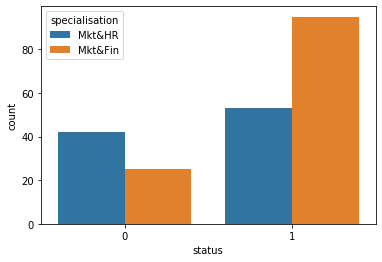

In [10]:
sns.countplot(x="status",hue="specialisation",data=data)

In [11]:
data['specialisation'] = data['specialisation'].map( {'Mkt&HR': 1,'Mkt&Fin': 2}).astype(int)

## ssc_p和hsc_p都顯示分數越高，越容易找到工作。

In [12]:
data[['ssc_p', 'status']].groupby(['status'], as_index=False).mean().sort_values(by='status', ascending=True)

,status,ssc_p
0,0,57.544030
1,1,71.721486


### 將ssc_p分成三部份 ，分數 > 73分的就業率高達 95%。

In [13]:
data['sscp_band'] = pd.qcut(data['ssc_p'],3)
data[['sscp_band', 'status']].groupby(['sscp_band'], as_index=False).mean().sort_values(by='status', ascending=True)

,sscp_band,status
0,"(40.889, 62.333]",0.319444
1,"(62.333, 73.0]",0.800000
2,"(73.0, 89.4]",0.955882


In [14]:
data = data.drop("sscp_band",axis = 1)

data.loc[ data['ssc_p'] <= 62.3, 'ssc_p'] = 1
data.loc[ (data['ssc_p'] > 62.3)&(data['ssc_p'] <= 73.00), 'ssc_p'] = 2
data.loc[ data['ssc_p'] > 73, 'ssc_p'] = 3

### 將hsc_p分成三部份 ，分數 > 70分的就業率高達 91%。

In [15]:
data['hscp_band'] = pd.qcut(data['hsc_p'],3)
data[['hscp_band', 'status']].groupby(['hscp_band'], as_index=False).mean().sort_values(by='status', ascending=True)

,hscp_band,status
0,"(36.999, 62.0]",0.466667
1,"(62.0, 70.0]",0.700000
2,"(70.0, 97.7]",0.914286


In [16]:
data = data.drop("hscp_band",axis = 1)

data.loc[ data['hsc_p'] <= 62.3, 'hsc_p'] = 1
data.loc[ (data['hsc_p'] > 62.3)&(data['hsc_p'] < 73.00), 'hsc_p'] = 2
data.loc[ data['hsc_p'] > 73, 'hsc_p'] = 3

### 我們將degree_p 做一樣的處理

In [17]:
data.loc[ data['degree_p'] <= 66, 'degree_p'] = 1
data.loc[ data['degree_p'] > 66, 'degree_p'] = 2

## 性別是男生找到工作的比例比女生略高一點。

In [18]:
data[['gender', 'status']].groupby(['gender'], as_index=False).mean().sort_values(by='status', ascending=True)

,gender,status
0,F,0.631579
1,M,0.719424


## 平均上看來ssc_b和hsc_b 這兩個features對於區分status沒有顯著的貢獻

In [19]:
data[['ssc_b', 'status']].groupby(['ssc_b'], as_index=False).mean().sort_values(by='status', ascending=True)

,ssc_b,status
0,Central,0.672414
1,Others,0.707071


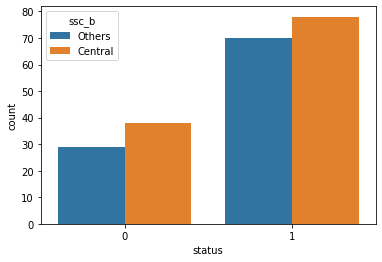

In [20]:
sns.countplot(x="status",hue="ssc_b",data=data)

In [21]:
data[['hsc_b', 'status']].groupby(['hsc_b'], as_index=False).mean().sort_values(by='status', ascending=True)

,hsc_b,status
0,Central,0.678571
1,Others,0.694656


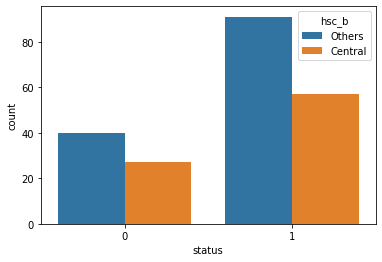

In [22]:
sns.countplot(x="status",hue="hsc_b",data=data)

In [23]:
data['gender'] = data['gender'].map({'M':1,'F':2}).astype(int)
data = data.drop(["ssc_b","hsc_b"],axis = 1)

## hsc_s平均上學習Science/Commerce 找到工作的比例幾乎一樣，人數上也相差不多。

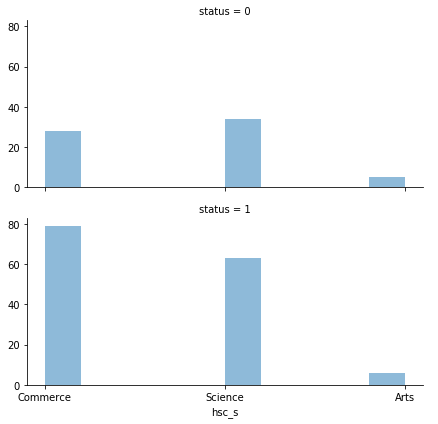

In [24]:
grid = sns.FacetGrid(data, row='status', height=3, aspect=2)
grid.map(plt.hist, 'hsc_s', alpha=.5, bins=10)
grid.add_legend()

In [25]:
data[['hsc_s', 'status']].groupby(['hsc_s'], as_index=False).mean().sort_values(by='status', ascending=True)

,hsc_s,status
0,Arts,0.545455
2,Science,0.692308
1,Commerce,0.699115


In [26]:
data['hsc_s'] = data['hsc_s'].map({'Arts':1,'Science':2,'Commerce':3}).astype(int)

# 實際train之前先整理一下目前觀察到的data的特性：
＊ ssc_p:
＊ hsc_p:
＊ hsc_s:
＊ degree_p:
＊ degree_t:
＊ workex:
＊ etest_p:
＊ specialisation:
＊ mba_p:

In [30]:
y = data['status']
data = data.drop(["status"],axis = 1)
data.head()

,gender,ssc_p,hsc_p,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p
0,1,2.0,3.0,3,1.0,2,2,55.0,1,58.80
1,1,3.0,3.0,2,2.0,2,1,86.5,2,66.28
2,1,2.0,2.0,1,1.0,3,2,75.0,2,57.80
3,1,1.0,1.0,2,1.0,2,2,66.0,1,59.43
4,1,3.0,3.0,3,2.0,3,2,96.8,2,55.50
